In [2]:
from __future__ import print_function, division, absolute_import
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL
from PIL import Image
from PIL import ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image, ImageEnhance, ImageFilter, ImageOps
import random
import math
from torch.nn import init

import pandas as pd
from torch.autograd import Variable,grad
import cv2
from scipy.linalg import sqrtm
import torch.optim as optim
from tqdm.notebook import tqdm as tqdm
import random
from collections import OrderedDict
import math
import torchvision.models as models
import lpips
from math import exp


import pytorch_msssim
from torchvision import transforms as trf
import collections
import copy

In [3]:
#모델 아키텍쳐 입니다.
def conv_batch(in_num, out_num, kernel_size=3, padding=1, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_num, out_num, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_num),
        nn.LeakyReLU())

class Darknet19(nn.Module):
    def __init__(self, cc, numboxes, device):
        super(Darknet19, self).__init__()
        self.conv1 = conv_batch(3, 32, kernel_size = [3,3])
        self.maxp1 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
        
        self.conv2 = conv_batch(32, 64, kernel_size = [3,3])
        self.maxp2 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
        
        self.conv3_1 = conv_batch(64, 128, kernel_size = [3,3])
        self.conv3_2 = conv_batch(128, 64, kernel_size = [1,1], padding=0)
        self.conv3_3 = conv_batch(64, 128, kernel_size = [3,3])
        self.maxp3 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
        
        self.conv4_1 = conv_batch(128, 256, kernel_size = [3,3])
        self.conv4_2 = conv_batch(256, 128, kernel_size = [1,1], padding=0)
        self.conv4_3 = conv_batch(128, 256, kernel_size = [3,3])
        self.maxp4 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
        
        self.conv5_1 = conv_batch(256, 512, kernel_size = [3,3])
        self.conv5_2 = conv_batch(512, 256, kernel_size = [1,1], padding =0)
        self.conv5_3 = conv_batch(256, 512, kernel_size = [3,3])
        self.conv5_4 = conv_batch(512, 256, kernel_size = [1,1], padding =0)
        self.conv5_5 = conv_batch(256, 512, kernel_size = [3,3])
        self.maxp5 = nn.MaxPool2d(kernel_size = [2,2], stride = 2)
        
        self.conv6_1 = conv_batch(512, 1024, kernel_size = [3,3])
        self.conv6_2 = conv_batch(1024, 512, kernel_size = [1,1], padding =0)
        self.conv6_3 = conv_batch(512, 1024, kernel_size = [3,3])
        self.conv6_4 = conv_batch(1024, 512, kernel_size = [1,1], padding =0)
        self.conv6_5 = conv_batch(512, 1024, kernel_size = [3,3])
        self.conv6_6 = conv_batch(1024, 1024, kernel_size = [3,3])
        self.conv6_7 = conv_batch(1024, 1024, kernel_size = [3,3])
        
        self.convfinal1_1 = conv_batch(3072,1024, kernel_size = [3,3])
        self.convfinal1_2 = nn.Conv2d(1024,numboxes*6, kernel_size=[1,1], stride=1, padding=0, bias=True)
        
        self.cx = Variable(torch.tensor(list(range(0,13))*13).reshape(13,13).float().T,requires_grad=False).to(device)
        self.cy = Variable(torch.tensor(list(range(0,13))*13).reshape(13,13).float(),requires_grad=False).to(device)
        self.pw = Variable(torch.moveaxis(torch.tensor(cc[:,0].tolist()*169).reshape(13,13,numboxes),-1,0),requires_grad=False).to(device)
        self.ph = Variable(torch.moveaxis(torch.tensor(cc[:,1].tolist()*169).reshape(13,13,numboxes),-1,0),requires_grad=False).to(device)
        
        self.numboxes = numboxes

#         dim = out.shape[2]
#         out2 = out.clone().cpu()

#         cx = torch.tensor(list(range(0,dim))*dim).reshape(dim,dim).T.float()
#         cy = torch.tensor(list(range(0,dim))*dim).reshape(dim,dim).float()
#         pw = torch.moveaxis(torch.tensor(cc[:,0].tolist()*(dim**2)).reshape(dim,dim,num_box),-1,0)
#         ph = torch.moveaxis(torch.tensor(cc[:,1].tolist()*(dim**2)).reshape(dim,dim,num_box),-1,0)

        
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        
        out = self.conv2(out)
        out = self.maxp2(out)
        
        out = self.conv3_1(out)
        out = self.conv3_2(out)
        out = self.conv3_3(out)
        out = self.maxp3(out)
        
        out = self.conv4_1(out)
        out = self.conv4_2(out)
        out = self.conv4_3(out)
        out = self.maxp4(out)

        out = self.conv5_1(out)
        out = self.conv5_2(out)
        out = self.conv5_3(out)
        out = self.conv5_4(out)
        out = self.conv5_5(out)
        out2 = out.clone()
        B,C,H,W = out2.size()
        out2 = out2.view(B, C, int(H/2), 2, int(W/2), 2).transpose(3,4).contiguous()
        out2 = out2.view(B, C, int(H/2*W/2), int(2*2)).transpose(2,3).contiguous()
        out2 = out2.view(B, C, int(2*2), int(H/2), int(W/2)).transpose(1,2).contiguous()
        out2 = out2.view(B, 2*2*C, int(H/2), int(W/2))
        out = self.maxp5(out)
        
        out = self.conv6_1(out)
        out = self.conv6_2(out)
        out = self.conv6_3(out)
        out = self.conv6_4(out)
        out = self.conv6_5(out)
        out = self.conv6_6(out)
        out = self.conv6_7(out)
        out = torch.cat([out,out2],dim=1)
        
        out = self.convfinal1_1(out)
        out = self.convfinal1_2(out)
        
        out[:,:self.numboxes*3,:,:] = torch.sigmoid(out[:,:self.numboxes*3,:,:])
        out[:,self.numboxes*5:,:,:] = torch.sigmoid(out[:,self.numboxes*5:,:,:])
        out[:,self.numboxes:self.numboxes*2,:,:] = out[:,self.numboxes:self.numboxes*2,:,:] + self.cx
        out[:,self.numboxes*2:self.numboxes*3,:,:] = out[:,self.numboxes*2:self.numboxes*3,:,:] + self.cy

        out[:,self.numboxes*3:self.numboxes*5,:,:] = torch.exp(out[:,self.numboxes*3:self.numboxes*5,:,:])
        out[:,self.numboxes*3:self.numboxes*4,:,:] = out[:,self.numboxes*3:self.numboxes*4,:,:] * self.pw
        out[:,self.numboxes*4:self.numboxes*5,:,:] = out[:,self.numboxes*4:self.numboxes*5,:,:] * self.ph
        return out

In [4]:
# v2
num_boxes=8
device = 'cpu' 
cc = np.load('YOLOv2_anchors_v.3.npy')
model = Darknet19(cc, num_boxes,device)
model.load_state_dict(torch.load('YOLOv2_model_v.3.pth',map_location=device))
model = model.to(device)
model.eval()

Darknet19(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (maxp1): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (maxp2): MaxPool2d(kernel_size=[2, 2], stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv3_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 1), strid

In [5]:
#iou라는 박스간의 intersection area proportion을 계산합니다.
def npiou(t1,t2):
    cx1,cy1,w1,h1 = t1[:,0], t1[:,1], t1[:,2], t1[:,3]
    cx2,cy2,w2,h2 = t2[:,0], t2[:,1], t2[:,2], t2[:,3]
    
    ltx1 = cx1 - w1/2
    lty1 = cy1 - h1/2
    rbx1 = cx1 + w1/2
    rby1 = cy1 + h1/2
    area1 = w1 * h1
    
    ltx2 = cx2 - w2/2
    lty2 = cy2 - h2/2
    rbx2 = cx2 + w2/2
    rby2 = cy2 + h2/2
    area2 = w2 * h2
    
    xm = np.vstack([ltx1,ltx2]).T.max(axis=1)
    ym = np.vstack([lty1,lty2]).T.max(axis=1)
    xmi = np.vstack([rbx1,rbx2]).T.min(axis=1)
    ymi = np.vstack([rby1,rby2]).T.min(axis=1)
    inter = (xmi-xm).clip(0) * (ymi-ym).clip(0)
    
    iou = inter/(area1+area2-inter)
    return iou

#Non-Max suppression 알고리즘을 수행하여, 필요없는 박스를 제외합니다.
def nms(out,conf_thres,iou_thres,num_boxes):
    t = torch.where(out[0][:num_boxes,:,:] > conf_thres)
    if len(torch.where(out[0][:num_boxes,:,:] >conf_thres)[0])==0:
        return []
    else:
        cx = out[0][num_boxes+t[0],t[1],t[2]].flatten().detach().cpu()*32
        cy = out[0][num_boxes*2+t[0],t[1],t[2]].flatten().detach().cpu()*32
        pw = out[0][num_boxes*3+t[0],t[1],t[2]]*32
        ph = out[0][num_boxes*4+t[0],t[1],t[2]]*32

        scores = np.array(out[0][t[0],t[1],t[2]])
        argscores = np.argsort(scores)
        scores = scores[argscores][::-1]
        bboxes= np.array(torch.vstack([cx,cy,pw,ph]).T)
        bboxes = bboxes[argscores][::-1]

        selecbox = []
        while len(bboxes)!=0:
            selecbox.append(bboxes[0])
            bboxes = bboxes[1:,:]
            if len(bboxes) == 0:
                break
            temprep = np.vstack([selecbox[-1]]*len(bboxes))
            bboxes = bboxes[npiou(bboxes,temprep) < iou_thres]
        return np.vstack(selecbox)
    
#모델에 들어가기전에 아웃풋을 알맞는 사이즈로 변형하고, padding 합니다.
def resizergray(pic,pixel = 416):
    ppic = np.array(pic)
    orsize = max(ppic.shape[:2])
    orsizemin = min(ppic.shape[:2])
    whichmax = np.argmax(ppic.shape)

    top = int((max(pic.size) - pic.size[1])/2)
    bottom = int((max(pic.size) - pic.size[1])/2)
    left = int((max(pic.size) - pic.size[0])/2)
    right = int((max(pic.size) - pic.size[0])/2)
    
    ppic = cv2.copyMakeBorder(ppic,top,bottom,left,right,borderType=cv2.BORDER_CONSTANT)
    ppic = Image.fromarray(ppic)
    ppic = ppic.resize((pixel,pixel))
    border = [top,bottom,left,right]
    return torch.tensor(np.asarray(ppic)[np.newaxis,:,:]).float(), border


#이미지에 박스를 그립니다.
def pil_draw_rect(image, x1, y1, x2, y2):
    draw = ImageDraw.Draw(image)
    draw.rectangle(((x1, y1), (x2, y2)))
    return image

def boxout(inp):
    cvimg = cv2.imread(inp)
    cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
    opic = Image.fromarray(cvimg)
    s1, s2, _ = np.array(opic).shape
    ms = max(s1,s2)
    padsize = int(abs(s1-s2)/2)

    if s1 > s2:
        where = 0
    else:
        where = 1

    pic, border = resizer(opic,pixel=416)
    result = model(pic/255).detach()
    boxes = nms(result,.6,.1,num_boxes)

    if len(boxes)==0:
        finalout = Image.fromarray(np.moveaxis(pic[0].detach().numpy(),0,-1).astype('uint8'))
    else:
        boxes = boxes[0]
        l = max(boxes[2],boxes[3])
        x1 = min(boxes[0] + (l/2) + ((l/2)*.30),416)
        y1 = min(boxes[1] + (l/2) + ((l/2)*.30),416)
        x2 = max(boxes[0] - (l/2) - ((l/2)*.30),0)
        y2 = max(boxes[1] - (l/2) - ((l/2)*.30),0)
        if x1 > pic[0].shape[2]:
            x1 = pic[0].shape[2]
        if x2 < 0: x2=0
        if y1 > pic[0].shape[1]:
            y1 = pic[0].shape[1]
        if y2 < 0: y2=0

        w = abs(x1-x2)
        h = abs(y1-y2)
        diff = abs(w-h)

    opic = np.moveaxis(np.array(opic),-1,0)[np.newaxis]

    if w > h:
        if where == 0 :
            c1 = ((y2-diff/2)/416)*s1
            c2 = ((y1+diff/2)/416)*s1
            c3 = (((x2)/416))*(s2+padsize*2)
            c4 = (((x1)/416))*(s2+padsize*2)

            c3 -= padsize
            c4 -= padsize
        else:
            c1 = ((y2-diff/2)/416)*(s1+padsize*2)
            c2 = ((y1+diff/2)/416)*(s1+padsize*2)
            c3 = (((x2)/416))*s2
            c4 = (((x1)/416))*s2

            c1 -= padsize
            c2 -= padsize
        c1 = np.array(c1).clip(0,opic.shape[2])
        c2 = np.array(c2).clip(0,opic.shape[2])
        c3 = np.array(c3).clip(0,opic.shape[3])
        c4 = np.array(c4).clip(0,opic.shape[3])
        image = Image.fromarray(np.moveaxis(opic[0][:,int(c1):int(c2),int(c3):int(c4)],0,-1).astype('uint8'))
    elif w < h:
        if where == 0 :
            c1 = ((y2-diff/2)/416)*s1
            c2 = ((y1+diff/2)/416)*s1
            c3 = (((x2)/416))*(s2+padsize*2)
            c4 = (((x1)/416))*(s2+padsize*2)

            c3 -= padsize
            c4 -= padsize
        else:
            c1 = ((y2-diff/2)/416)*(s1+padsize*2)
            c2 = ((y1+diff/2)/416)*(s1+padsize*2)
            c3 = (((x2)/416))*s2
            c4 = (((x1)/416))*s2

            c1 -= padsize
            c2 -= padsize
        c1 = np.array(c1).clip(0,opic.shape[2])
        c2 = np.array(c2).clip(0,opic.shape[2])
        c3 = np.array(c3).clip(0,opic.shape[3])
        c4 = np.array(c4).clip(0,opic.shape[3])
        image = Image.fromarray(np.moveaxis(opic[0][:,int(c1):int(c2),int(c3):int(c4)],0,-1).astype('uint8'))
    else:
        if where == 0 :
            c1 = ((y2)/416)*s1
            c2 = ((y1)/416)*s1
            c3 = (((x2)/416))*(s2+padsize*2)
            c4 = (((x1)/416))*(s2+padsize*2)

            c3 -= padsize
            c4 -= padsize
        else:
            c1 = ((y2)/416)*(s1+padsize*2)
            c2 = ((y1)/416)*(s1+padsize*2)
            c3 = (((x2)/416))*(s2)
            c4 = (((x1)/416))*s2

            c1 -= padsize
            c2 -= padsize
        c1 = np.array(c1).clip(0,opic.shape[2])
        c2 = np.array(c2).clip(0,opic.shape[2])
        c3 = np.array(c3).clip(0,opic.shape[3])
        c4 = np.array(c4).clip(0,opic.shape[3])
        image = Image.fromarray(np.moveaxis(opic[0][:,int(c1):int(c2),int(c3):int(c4)],0,-1).astype('uint8'))

    if np.array(image).shape[0]!=np.array(image).shape[1]:
        image,_ = resizer(image,pixel = max(np.array(image).shape))
        image = Image.fromarray(image[0].permute(1,2,0).detach().numpy().astype('uint8'))
        
    finalout = image
    return finalout

In [6]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)

    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x


class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None

        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))

        if not grow_first:
            rep.append(nn.ReLU(inplace=True))
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x


class Xception(nn.Module):
    """
    Xception optimized for the ImageNet dataset, as specified in
    https://arxiv.org/pdf/1610.02357.pdf
    """
    def __init__(self, num_classes=1000):
        """ Constructor
        Args:
            num_classes: number of classes
        """
        super(Xception, self).__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        #do relu here

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)
        self.relu3 = nn.ReLU(inplace=True)

        #do relu here
        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)
        self.relu4 = nn.ReLU(inplace=True)

        self.fc = nn.Linear(2048, 136)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = F.adaptive_avg_pool2d(x, (1, 1)) 
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [7]:
# landmark
device = 'cpu' 
lmm = Xception()
lmm.load_state_dict(torch.load('LMD_xception_v.3.pth',map_location=device))
lmm = lmm.to(device)
lmm.eval()

Xception(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (block1): Block(
    (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (rep): Sequential(
      (0): SeparableConv2d(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): SeparableConv2d(
        (conv1): Co

In [8]:
def angle(lex,ley,rex,rey):
    lx = lex.mean()
    ly = ley.mean()
    rx = rex.mean()# landmark
    ry = rey.mean()
    sign= ((rx-lx)/abs(lx-rx))
    w= abs(rx-lx)
    h = abs(ry-ly)
    angle = sign * ((ry-ly)/abs(ly-ry)) * (math.atan(h/w)* 180 / math.pi)
    if abs(angle) < 7:
        angle = 0
    if sign < 0:
        angle += 180
    return angle

In [46]:
def face_cutting(picture):
    out = boxout(picture)
    sample = resizergray(ImageOps.grayscale(out),pixel=224)[0]/255
    pred = lmm(sample[np.newaxis,:,:,:])
    x = pred.detach().cpu().numpy()[0][:68]*224
    y = pred.detach().cpu().numpy()[0][68:]*224
    tid = 36
    rex = x[tid:tid+6]
    rey = y[tid:tid+6]
    lex = x[tid+6:tid+12]
    ley = y[tid+6:tid+12]
    ang = angle(lex,ley,rex,rey)
    rout = out.rotate(ang)

    sample = resizergray(ImageOps.grayscale(rout),pixel=224)[0]/255
    pred = lmm(sample[np.newaxis,:,:,:])
    x = pred.detach().cpu().numpy()[0][:68]*224
    y = pred.detach().cpu().numpy()[0][68:]*224
    tid = 36
    rex = x[tid:tid+6].mean()
    rey = y[tid:tid+6].mean()
    lex = x[tid+6:tid+12].mean()
    ley = y[tid+6:tid+12].mean()

    rout = np.array(rout)

    s1,s2,_ = rout.shape
    padsize = int(abs(s1-s2)/2)
    if s1 > s2:
        where = 0
    else:
        where = 1
    if where == 0:
        rex -= (padsize/s1)*224
        lex -= (padsize/s1)*224
    else:
        ley -= (padsize/s2)*224
        rey -= (padsize/s2)*224

    xc = (lex + abs(rex-lex)/2)/224
    yc = (min(ley,rey) + abs(ley-rey)/2)/224

    rs1,rs2,_ = rout.shape

    if (.5-xc) > 0:
        cut = rs2 * abs(.5-xc) * 2
        rout = rout[:,:int(rs2-cut),:]
    else:
        cut = rs2 * abs(.5-xc) * 2
        rout = rout[:,int(cut):,:]

    if (.5-yc) > 0:
        cut = rs1*abs(.5-yc) * 2
        rout = rout[:int(rs1-cut),:,:]
    else:
        cut = rs1*abs(.5-yc) * 2
        rout = rout[int(cut):,:,:]

    if rout.shape[1] > rout.shape[0]:
        cut = int(abs(rout.shape[1]-rout.shape[0])/2)
        rout = rout[:,cut:rout.shape[1]-cut,:]
    else:
        cut = int(abs(rout.shape[0]-rout.shape[0])/2)    
        rout = rout[cut:rout.shape[0]-cut,:,:]
    
    return  Image.fromarray(rout)

In [10]:
# def face_cutting(picture):
#     out = boxout(picture)
#     sample = resizergray(ImageOps.grayscale(out),pixel=224)[0]/255
#     samplec = resizer(out,pixel=224)[0]
#     pred = lmm(sample[np.newaxis,:,:,:])
#     x = pred.detach().cpu().numpy()[0][:68]*224
#     y = pred.detach().cpu().numpy()[0][68:]*224
#     tid = 36
#     rex = x[tid:tid+6]
#     rey = y[tid:tid+6]
#     lex = x[tid+6:tid+12]
#     ley = y[tid+6:tid+12]
#     ang = angle(lex,ley,rex,rey)
    
#     return out.rotate(ang)

In [11]:
class MyLinear(nn.Module):
    """Linear layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_size, output_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True):
        super().__init__()
        he_std = gain * input_size**(-0.5) # He init
        # Equalized learning rate and custom learning rate multiplier.
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_size, input_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_size))
            self.b_mul = lrmul
        else:
            self.bias = None

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        return F.linear(x, self.weight * self.w_mul, bias)
    
class MyConv2d(nn.Module):
    """Conv layer with equalized learning rate and custom learning rate multiplier."""
    def __init__(self, input_channels, output_channels, kernel_size, gain=2**(0.5), use_wscale=False, lrmul=1, bias=True,
                intermediate=None, upscale=False):
        super().__init__()
        if upscale:
            self.upscale = Upscale2d()
        else:
            self.upscale = None
        he_std = gain * (input_channels * kernel_size ** 2) ** (-0.5) # He init
        self.kernel_size = kernel_size
        if use_wscale:
            init_std = 1.0 / lrmul
            self.w_mul = he_std * lrmul
        else:
            init_std = he_std / lrmul
            self.w_mul = lrmul
        self.weight = torch.nn.Parameter(torch.randn(output_channels, input_channels, kernel_size, kernel_size) * init_std)
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(output_channels))
            self.b_mul = lrmul
        else:
            self.bias = None
        self.intermediate = intermediate

    def forward(self, x):
        bias = self.bias
        if bias is not None:
            bias = bias * self.b_mul
        
        have_convolution = False
        if self.upscale is not None and min(x.shape[2:]) * 2 >= 128:
            # this is the fused upscale + conv from StyleGAN, sadly this seems incompatible with the non-fused way
            # this really needs to be cleaned up and go into the conv...
            w = self.weight * self.w_mul
            w = w.permute(1, 0, 2, 3)
            # probably applying a conv on w would be more efficient. also this quadruples the weight (average)?!
            w = F.pad(w, (1,1,1,1))
            w = w[:, :, 1:, 1:]+ w[:, :, :-1, 1:] + w[:, :, 1:, :-1] + w[:, :, :-1, :-1]
            x = F.conv_transpose2d(x, w, stride=2, padding=(w.size(-1)-1)//2)
            have_convolution = True
        elif self.upscale is not None:
            x = self.upscale(x)
    
        if not have_convolution and self.intermediate is None:
            return F.conv2d(x, self.weight * self.w_mul, bias, padding=self.kernel_size//2)
        elif not have_convolution:
            x = F.conv2d(x, self.weight * self.w_mul, None, padding=self.kernel_size//2)
        
        if self.intermediate is not None:
            x = self.intermediate(x)
        if bias is not None:
            x = x + bias.view(1, -1, 1, 1)
        return x
    
class NoiseLayer(nn.Module):
    """adds noise. noise is per pixel (constant over channels) with per-channel weight"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None
    
    def forward(self, x): # noise=None
        x, noise = x
        if noise is None and self.noise is None:
            noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device, dtype=x.dtype)
        elif noise is None:
            # here is a little trick: if you get all the noisselayers and set each
            # modules .noise attribute, you can have pre-defined noise.
            # Very useful for analysis
            noise = self.noise
        x = x + self.weight.view(1, -1, 1, 1) * noise
        return x
    
class StyleMod(nn.Module):
    def __init__(self, latent_size, channels, use_wscale):
        super(StyleMod, self).__init__()
        self.lin = MyLinear(latent_size,
                            channels * 2,
                            gain=1.0, use_wscale=use_wscale)
        
    def forward(self, x, latent):
        style = self.lin(latent) # style => [batch_size, n_channels*2]
        shape = [-1, 2, x.size(1)] + (x.dim() - 2) * [1]
        style = style.view(shape)  # [batch_size, 2, n_channels, ...]
        x = x * (style[:, 0] + 1.) + style[:, 1]
        return x
    
class PixelNormLayer(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, x):
        return x * torch.rsqrt(torch.mean(x**2, dim=1, keepdim=True) + self.epsilon)

class BlurLayer(nn.Module):
    def __init__(self, kernel=[1, 2, 1], normalize=True, flip=False, stride=1):
        super(BlurLayer, self).__init__()
        kernel=[1, 2, 1]
        kernel = torch.tensor(kernel, dtype=torch.float32)
        kernel = kernel[:, None] * kernel[None, :]
        kernel = kernel[None, None]
        if normalize:
            kernel = kernel / kernel.sum()
        if flip:
            kernel = kernel[:, :, ::-1, ::-1]
        self.register_buffer('kernel', kernel)
        self.stride = stride
    
    def forward(self, x):
        # expand kernel channels
        kernel = self.kernel.expand(x.size(1), -1, -1, -1)
        x = F.conv2d(
            x,
            kernel,
            stride=self.stride,
            padding=int((self.kernel.size(2)-1)/2),
            groups=x.size(1)
        )
        return x

def upscale2d(x, factor=2, gain=1):
    assert x.dim() == 4
    if gain != 1:
        x = x * gain
    if factor != 1:
        shape = x.shape
        x = x.view(shape[0], shape[1], shape[2], 1, shape[3], 1).expand(-1, -1, -1, factor, -1, factor)
        x = x.contiguous().view(shape[0], shape[1], factor * shape[2], factor * shape[3])
    return x

class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1):
        super().__init__()
        assert isinstance(factor, int) and factor >= 1
        self.gain = gain
        self.factor = factor
    def forward(self, x):
        return upscale2d(x, factor=self.factor, gain=self.gain)

class G_mapping(nn.Sequential):
    def __init__(self, nonlinearity='lrelu', use_wscale=True):
        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        layers = [
            ('pixel_norm', PixelNormLayer()),
            ('dense0', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense0_act', act),
            ('dense1', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense1_act', act),
            ('dense2', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense2_act', act),
            ('dense3', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense3_act', act),
            ('dense4', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense4_act', act),
            ('dense5', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense5_act', act),
            ('dense6', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense6_act', act),
            ('dense7', MyLinear(512, 512, gain=gain, lrmul=0.01, use_wscale=use_wscale)),
            ('dense7_act', act)
        ]
        super().__init__(OrderedDict(layers))
        
    def forward(self, x):
        x = super().forward(x)
        # Broadcast
        x = x.unsqueeze(1).expand(-1, 18, -1)
        return x

class Truncation(nn.Module):
    def __init__(self, avg_latent, max_layer=8, threshold=0.7):
        super().__init__()
        self.max_layer = max_layer
        self.threshold = threshold
        self.register_buffer('avg_latent', avg_latent)
    def forward(self, x):
        assert x.dim() == 3
        interp = torch.lerp(self.avg_latent, x, self.threshold)
        do_trunc = (torch.arange(x.size(1)) < self.max_layer).view(1, -1, 1)
        return torch.where(do_trunc, interp, x)
class LayerEpilogue(nn.Module):
    """Things to do at the end of each layer."""
    def __init__(self, channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        layers = []
        if use_noise:
            layers.append(('noise', NoiseLayer(channels)))
        layers.append(('activation', activation_layer))
        if use_pixel_norm:
            layers.append(('pixel_norm', PixelNorm()))
        if use_instance_norm:
            layers.append(('instance_norm', nn.InstanceNorm2d(channels)))
        self.top_epi = nn.Sequential(OrderedDict(layers))
        if use_styles:
            self.style_mod = StyleMod(dlatent_size, channels, use_wscale=use_wscale)
        else:
            self.style_mod = None
    def forward(self, x, noise, dlatents_in_slice=None):
        x = self.top_epi((x,noise))
        if self.style_mod is not None:
            x = self.style_mod(x, dlatents_in_slice)
        else:
            assert dlatents_in_slice is None
        return x


class InputBlock(nn.Module):
    def __init__(self, nf, dlatent_size, const_input_layer, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.nf = nf
        if self.const_input_layer:
            # called 'const' in tf
            self.const = nn.Parameter(torch.ones(1, nf, 4, 4))
            self.bias = nn.Parameter(torch.ones(nf))
        else:
            self.dense = MyLinear(dlatent_size, nf*16, gain=gain/4, use_wscale=use_wscale) # tweak gain to match the official implementation of Progressing GAN
        self.epi1 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv = MyConv2d(nf, nf, 3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(nf, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        
    def forward(self, dlatents_in_range, noises):
        batch_size = dlatents_in_range.size(0)
        if self.const_input_layer:
            x = self.const.expand(batch_size, -1, -1, -1)
            x = x + self.bias.view(1, -1, 1, 1)
        else:
            x = self.dense(dlatents_in_range[:, 0]).view(batch_size, self.nf, 4, 4)

        x = self.epi1(x, noises[0], dlatents_in_range[:, 0])
        x = self.conv(x)
        x = self.epi2(x, noises[1], dlatents_in_range[:, 1])
        return x


class GSynthesisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer):
        # 2**res x 2**res # res = 3..resolution_log2
        super().__init__()
        if blur_filter:
            blur = BlurLayer(blur_filter)
        else:
            blur = None
        self.conv0_up = MyConv2d(in_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale,
                                 intermediate=blur, upscale=True)
        self.epi1 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
        self.conv1 = MyConv2d(out_channels, out_channels, kernel_size=3, gain=gain, use_wscale=use_wscale)
        self.epi2 = LayerEpilogue(out_channels, dlatent_size, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, activation_layer)
            
    def forward(self, x, dlatents_in_range, noises):
        x = self.conv0_up(x)
        x = self.epi1(x, noises[0], dlatents_in_range[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, noises[1], dlatents_in_range[:, 1])
        return x

class G_synthesis(nn.Module):
    def __init__(self,
        dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
        num_channels        = 3,            # Number of output color channels.
        resolution          = 1024,         # Output resolution.
        fmap_base           = 8192,         # Overall multiplier for the number of feature maps.
        fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
        fmap_max            = 512,          # Maximum number of feature maps in any layer.
        use_styles          = True,         # Enable style inputs?
        const_input_layer   = True,         # First layer is a learned constant?
        use_noise           = True,         # Enable noise inputs?
        randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
        nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu'
        use_wscale          = True,         # Enable equalized learning rate?
        use_pixel_norm      = False,        # Enable pixelwise feature vector normalization?
        use_instance_norm   = True,         # Enable instance normalization?
        dtype               = torch.float32,  # Data type to use for activations and outputs.
        blur_filter         = [1,2,1],      # Low-pass filter to apply when resampling activations. None = no filtering.
        ):
        
        super().__init__()
        def nf(stage):
            return min(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_max)
        self.dlatent_size = dlatent_size
        resolution_log2 = int(np.log2(resolution))
        assert resolution == 2**resolution_log2 and resolution >= 4

        act, gain = {'relu': (torch.relu, np.sqrt(2)),
                     'lrelu': (nn.LeakyReLU(negative_slope=0.2), np.sqrt(2))}[nonlinearity]
        num_layers = resolution_log2 * 2 - 2
        num_styles = num_layers if use_styles else 1
        torgbs = []
        blocks = []
        for res in range(2, resolution_log2 + 1):
            channels = nf(res-1)
            name = '{s}x{s}'.format(s=2**res)
            if res == 2:
                blocks.append((name,
                               InputBlock(channels, dlatent_size, const_input_layer, gain, use_wscale,
                                      use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
                
            else:
                blocks.append((name,
                               GSynthesisBlock(last_channels, channels, blur_filter, dlatent_size, gain, use_wscale, use_noise, use_pixel_norm, use_instance_norm, use_styles, act)))
            last_channels = channels
        self.torgb = MyConv2d(channels, num_channels, 1, gain=1, use_wscale=use_wscale)
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        
    def forward(self, dlatents_in,noises):
        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
        # lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0), trainable=False), dtype)
        batch_size = dlatents_in.size(0)       
        for i, m in enumerate(self.blocks.values()):
            if i == 0:
                x = m(dlatents_in_range = dlatents_in[:, 2*i:2*i+2],noises = [noises[i],noises[i+1]])
            else:
                x = m(x = x, dlatents_in_range = dlatents_in[:, 2*i:2*i+2],noises = [noises[i*2],noises[i*2+1]])
        rgb = self.torgb(x)
        return rgb, dlatents_in

In [12]:
class vgg16_encoder(nn.Module):
    def __init__(self):
        super(vgg16_encoder,self).__init__()
        self.features_0 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_1 = nn.ReLU(inplace=True)
        self.features_2 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_3 = nn.ReLU(inplace=True)
        self.features_4 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.features_5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_6 = nn.ReLU(inplace=True)
        self.features_7 = nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_8 = nn.ReLU(inplace=True)
        self.features_9 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.features_10 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_11 = nn.ReLU(inplace=True)
        self.features_12 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_13 = nn.ReLU(inplace=True)
        self.features_14 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_15 = nn.ReLU(inplace=True)
        self.features_16 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.features_17 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_18 = nn.ReLU(inplace=True)
        self.features_19 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_20 = nn.ReLU(inplace=True)
        self.features_21 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_22 = nn.ReLU(inplace=True)
        self.features_23 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.features_24 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_25 = nn.ReLU(inplace=True)
        self.features_26 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_27 = nn.ReLU(inplace=True)
        self.features_28 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.features_29 = nn.ReLU(inplace=True)
        self.features_30 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))
        self.lin = nn.Linear(25088,512)
        
    def forward(self, x, all_out=False):
        x0 = self.features_0(x)
        x1 = self.features_1(x0)
        x2 = self.features_2(x1)
        x3 = self.features_3(x2)
        x4 = self.features_4(x3)
        x5 = self.features_5(x4)
        x6 = self.features_6(x5)
        x7 = self.features_7(x6)
        x8 = self.features_8(x7)
        x9 = self.features_9(x8)
        x10 = self.features_10(x9)
        x11 = self.features_11(x10)
        x12 = self.features_12(x11)
        x13 = self.features_13(x12)
        x14 = self.features_14(x13)
        x15 = self.features_15(x14)
        x16 = self.features_16(x15)
        x17 = self.features_17(x16)
        x18 = self.features_18(x17)
        x19 = self.features_19(x18)
        x20 = self.features_20(x19)
        x21 = self.features_21(x20)
        x22 = self.features_22(x21)
        x23 = self.features_23(x22)
        x24 = self.features_24(x23)
        x25 = self.features_25(x24)
        x26 = self.features_26(x25)
        x27 = self.features_27(x26)
        x28 = self.features_28(x27)
        x29 = self.features_29(x28)
        x30 = self.features_30(x29)
        pool = self.avgpool(x30)
        pool_flat = pool.flatten(1)
        x31 = self.lin(pool_flat)
        if all_out:
            return [x1,x3,x6,x8,x11,x13,x15,x18,x20,x22,x25,x27,x29,x31]
        else:
            return x31

In [13]:
#resnet init
class latent(nn.Module):
    def __init__(self,w_pred,noise = None):
        super().__init__()
        self.w = nn.Parameter(w_pred)
        self.n1 = nn.Parameter(torch.randn(1,1,4,4))
        self.n2 = nn.Parameter(torch.randn(1,1,4,4))
        self.n3 = nn.Parameter(torch.randn(1,1,8,8))
        self.n4 = nn.Parameter(torch.randn(1,1,8,8))
        self.n5 = nn.Parameter(torch.randn(1,1,16,16))
        self.n6 = nn.Parameter(torch.randn(1,1,16,16))
        self.n7 = nn.Parameter(torch.randn(1,1,32,32))
        self.n8 = nn.Parameter(torch.randn(1,1,32,32))
        self.n9 = nn.Parameter(torch.randn(1,1,64,64))
        self.n10 = nn.Parameter(torch.randn(1,1,64,64))
        self.n11 = nn.Parameter(torch.randn(1,1,128,128))
        self.n12 = nn.Parameter(torch.randn(1,1,128,128))
        self.n13 = nn.Parameter(torch.randn(1,1,256,256))
        self.n14 = nn.Parameter(torch.randn(1,1,256,256))
        self.n15 = nn.Parameter(torch.randn(1,1,512,512))
        self.n16 = nn.Parameter(torch.randn(1,1,512,512))
        self.n17 = nn.Parameter(torch.randn(1,1,1024,1024))
        self.n18 = nn.Parameter(torch.randn(1,1,1024,1024))
        
        if noise != None:
            self.n1 = nn.Parameter(noise[0])
            self.n2 = nn.Parameter(noise[1])
            self.n3 = nn.Parameter(noise[2])
            self.n4 = nn.Parameter(noise[3])
            self.n5 = nn.Parameter(noise[4])
            self.n6 = nn.Parameter(noise[5])
            self.n7 = nn.Parameter(noise[6])
            self.n8 = nn.Parameter(noise[7])
            self.n9 = nn.Parameter(noise[8])
            self.n10 = nn.Parameter(noise[9])
            self.n11 = nn.Parameter(noise[10])
            self.n12 = nn.Parameter(noise[11])
            self.n13 = nn.Parameter(noise[12])
            self.n14 = nn.Parameter(noise[13])
            self.n15 = nn.Parameter(noise[14])
            self.n16 = nn.Parameter(noise[15])
            self.n17 = nn.Parameter(noise[16])
            self.n18 = nn.Parameter(noise[17])
                
    def forward(self,):
        return (self.w, [self.n1,self.n2,self.n3,
                        self.n4,self.n5,self.n6,
                        self.n7,self.n8,self.n9,
                        self.n10,self.n11,self.n12,
                        self.n13,self.n14,self.n15,
                        self.n16,self.n17,self.n18,])

In [99]:
def noise_penalty(noise_map):
    result = [noise_map]
    penalty = 0
    while result[-1].shape[-1] > 8:
        result.append(2 * F.avg_pool2d(result[-1],2))
    for i in range(len(result)):
        temp = ((result[i][:,:,1:,:] * result[i][:,:,:-1,:]).sum()/(result[i].shape[-1]**2))**2 + \
        ((result[i][:,:,:,1:] * result[i][:,:,:,:-1]).sum()/(result[i].shape[-1]**2))**2
        penalty += temp
    return penalty

def lr_calc(epoch,max_lr):
    if (epoch > 49) and (epoch < 750):
        return max_lr
    if epoch < 50:
        return (max_lr/50) * (epoch + 1)
    else:
        return max_lr - (max_lr/250)*(epoch-750)

In [100]:
resnet50_encoder = models.resnet50()
resnet50_encoder.fc = nn.Linear(2048,512*18)
resnet50_encoder.load_state_dict(torch.load('resnet_encoder_loaded.pth'))
resnet50_encoder.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [101]:
mapnet = G_mapping()
gen = G_synthesis()
mapnet.load_state_dict(torch.load('mapnet_loaded.pth'))
gen.load_state_dict(torch.load('gen_loaded.pth'))
mapnet.eval()
gen.eval()

G_synthesis(
  (torgb): MyConv2d()
  (blocks): ModuleDict(
    (4x4): InputBlock(
      (epi1): LayerEpilogue(
        (top_epi): Sequential(
          (noise): NoiseLayer()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
      )
      (conv): MyConv2d()
      (epi2): LayerEpilogue(
        (top_epi): Sequential(
          (noise): NoiseLayer()
          (activation): LeakyReLU(negative_slope=0.2)
          (instance_norm): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        )
        (style_mod): StyleMod(
          (lin): MyLinear()
        )
      )
    )
    (8x8): GSynthesisBlock(
      (conv0_up): MyConv2d(
        (upscale): Upscale2d()
        (intermediate): BlurLayer()
      )
      (epi1): LayerEpilogue(
        (top_epi): Sequential(
    

In [102]:
device = 'cpu'
bmi_predictor = models.resnet50(pretrained=True)
bmi_predictor.fc = nn.Linear(2048,1)
bmi_predictor.to(device)
bmi_predictor.load_state_dict(torch.load('BMI_mapper_trf2.pth'))

### takes 3 x 224 x 224 as input
testimg_transform = trf.Compose([
    trf.Normalize([.5,.5,.5],[.5,.5,.5]),
])

In [103]:
vgg_modified = collections.OrderedDict()
vgg16 = models.vgg16(pretrained=True)
temp = vgg16.state_dict()
for key,val in temp.items():
    name = key
    if key.startswith('features'):
        splited = name.split('.')
        name = splited[0]+'_'+splited[1]+'.'+splited[2]
    vgg_modified[name] = copy.deepcopy(val)
vggencoder = vgg16_encoder()
pretrained_dict = vgg_modified
new_model_dict = vgg16_encoder().state_dict()
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in new_model_dict}
new_model_dict.update(pretrained_dict)
vggencoder.load_state_dict(new_model_dict)

<All keys matched successfully>

In [104]:
#loss multiplier (constants)
lam_pixel,lam_vgg,lam_ssim,lam_percept,lam_penalty, lam_d = \
(1.5,.4,200,100,.5,0.5)

fat_dir = torch.tensor(np.load('fat_direction.npy')).float().reshape(1,18,512)
fat_dir = fat_dir/torch.norm(fat_dir,2)

In [105]:
### loss_fns
vgglpip = lpips.LPIPS(net='vgg')
def log_cosh_loss(x_pred, x_p):
    def _log_cosh(x):
        return x + F.softplus(-2. * x) - math.log(2.0)
    return torch.mean(_log_cosh(x_pred - x_p))

def vggloss(pred_vgg,true_vgg):
    diff = []
    for i in range(len(pred_vgg)):
        if len(pred_vgg[i].shape)==4:
            n,c,w,h = pred_vgg[i].shape
            nparam = c*w*h
        if len(pred_vgg[i].shape)==2:
            n,d = pred_vgg[i].shape
            nparam = n*d
        l1norm = torch.norm((pred_vgg[i]-true_vgg[i]).flatten(1),1,1)/(nparam)
        diff.append(l1norm)
    return torch.sum(torch.tensor(diff).float())

def lpenalty(z_pred,z_batch):
    z_avg = z_batch.mean(0)
    return torch.mean(torch.norm(z_pred-z_avg,1,1))

# def ld(discrim,x_pred):
#     scores = discrim(x_pred)
#     return torch.mean(scores)

def lpercept(x_pred,x_true):
    d = vgglpip.forward(x_pred,x_true).flatten()
    return d

def lssim(x_pred,x_true):
    return pytorch_msssim.ms_ssim(x_pred,x_true)

def mse(x_pred,x_true):
    n,c,w,h = x_pred.shape
    return torch.norm(x_pred-x_true,2)/(c*w*h)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /opt/conda/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


In [106]:
def requires_grad(model, flag=True):
    for p in model.parameters():
        p.requires_grad = flag

requires_grad(gen,False)
requires_grad(mapnet,False)
requires_grad(vggencoder,False)

In [107]:
norm = trf.Normalize((.5,.5,.5),(.5,.5,.5))
invTrans = trf.Compose([ trf.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.5, 1/0.5, 1/0.5 ]),
                                trf.Normalize(mean = [ -0.5, -0.5, -0.5 ],
                                                     std = [ 1., 1., 1. ]),
                               ])

In [108]:
def chooseimg():
    import random
    impath = '/home/jovyan/tf/AA002/StyleGAN/Data/pictures2/CelebAMask-HQ/CelebA-HQ-img/'
    impath = impath + os.listdir('/home/jovyan/tf/AA002/StyleGAN/Data/pictures2/CelebAMask-HQ/CelebA-HQ-img')[random.randint(0,10000)]
    imsize = Image.open(impath).size
    cutsize = int((max(imsize)-min(imsize))/2)
    if np.argmax(imsize)==1:
        testimg = np.array(Image.open(impath))[cutsize:max(imsize)-cutsize,:,:]
    else:
        testimg = np.array(Image.open(impath))[:,cutsize:max(imsize)-cutsize,:]
    testimg = torch.tensor(np.array(Image.fromarray(testimg).resize((1024,1024)))).float() / 255
    testimg = (testimg.permute(2,0,1)*2 - 1)[np.newaxis]
    return testimg

In [109]:
#need to add processing step (YOLO + Xception)
def load_img(impath):
    img = face_cutting(impath)
    imsize = img.size
    cutsize = int((max(imsize)-min(imsize))/2)
    if np.argmax(imsize)==1:
        testimg = np.array(img)[cutsize:max(imsize)-cutsize,:,:]
    else:
        testimg = np.array(img)[:,cutsize:max(imsize)-cutsize,:]
    testimg = torch.tensor(np.array(Image.fromarray(testimg).resize((1024,1024)))).float() / 255
    testimg = (testimg.permute(2,0,1)*2 - 1)[np.newaxis]
    return testimg

In [110]:
def resizer(pic,pixel = 416):
    ppic = np.array(pic)
    orsize = max(ppic.shape[:2])
    orsizemin = min(ppic.shape[:2])
    whichmax = np.argmax(ppic.shape)

    top = int((max(ppic.shape) - ppic.shape[0])/2)
    bottom = int((max(ppic.shape) - ppic.shape[0])/2)
    left = int((max(ppic.shape) - ppic.shape[1])/2)
    right = int((max(ppic.shape) - ppic.shape[1])/2)

    ppic = cv2.copyMakeBorder(ppic,top,bottom,left,right,borderType=cv2.BORDER_CONSTANT)
    ppic = Image.fromarray(ppic)
    ppic = ppic.resize((pixel,pixel))
    border = [top,bottom,left,right]
    return torch.tensor(np.moveaxis(np.asarray(ppic),-1,0)[np.newaxis,:,:,:]).float(), border

def bmi_pred(img):
    bmi_predictor.eval()
    with torch.no_grad():
        preds = []
        img,_ = resizer(img,pixel=224)
        for i in range(1):
            pred = bmi_predictor(testimg_transform(img/255))*55
            preds.append(pred.item())
    return np.mean(preds)

In [111]:
def img_processor(imgtensor,dim):
    imgtensor = (imgtensor[0].permute(1,2,0).clip(-1,1)+1)/2
    return Image.fromarray((imgtensor.detach().numpy()*255).astype('uint8')).resize((dim,dim))

In [123]:
# takes two inputs 'current bmi', and 'simulated bmi'
def fatmaker(currentbmi,simbmi,l,dim):
    with torch.no_grad():
        gen.cpu()
        l.cpu()
        l.eval()
        w,noises = l()
        diff_sim = simbmi - currentbmi
        if diff_sim > 0:
            x_fat,_ = gen(w,noises)
            x_fat20,_ = gen(w + 20*fat_dir,noises)
            x_fat = img_processor(x_fat,224)
            x_fat20 = img_processor(x_fat20,224)
            diff_alpha = abs(20/(bmi_pred(x_fat20)-bmi_pred(x_fat)))
            alpha = diff_sim * diff_alpha
            alpha = min(alpha,30)
            
        else:
            x_fat,_ = gen(w,noises)
            x_fat20,_ = gen(w - 20*fat_dir,noises)
            x_fat = img_processor(x_fat,224)
            x_fat20 = img_processor(x_fat20,224)
            diff_alpha = abs(20/(bmi_pred(x_fat)-bmi_pred(x_fat20)))
            alpha = diff_sim * diff_alpha
            alpha = max(alpha,-10)
            
        original,_ = gen(w,noises)
        fatimg,_ = gen(w + alpha*fat_dir,noises)        
        
        fatimg = img_processor(fatimg,dim)
        original = img_processor(original,dim)
        
        fr = float(np.array(fatimg)[:,:,0].sum())
        fg = float(np.array(fatimg)[:,:,1].sum())
        fb = float(np.array(fatimg)[:,:,2].sum())

        orr = float(np.array(original)[:,:,0].sum())
        org = float(np.array(original)[:,:,1].sum())
        orb = float(np.array(original)[:,:,2].sum())

        rc = 1 + ((orr-fr)/fr)
        gc = 1 + ((org-fg)/fg)
        bc = 1 + ((orb-fb)/fb)

        new = np.stack([np.array(fatimg)[:,:,0].astype('float')*rc,np.array(fatimg)[:,:,1].astype('float')*gc,\
                        np.array(fatimg)[:,:,2].astype('float')*bc])
        new = np.moveaxis(new,0,-1)
        new = new.clip(0,255).astype('uint8')
        return Image.fromarray(new)

In [293]:
def train_latent(testimg):
    ws_m = torch.tensor(np.load('ws_m.npy')).float()
    ws_std = torch.tensor(np.load('ws_std.npy')).float()
    with torch.no_grad():
        w_pred = ws_m
        w_pred = w_pred.reshape(1,18,512)
        losses = []
    l = latent(w_pred)

    device = 'cuda'
    gen.to(device)
    l.to(device)
    vgglpip.to(device)
    vggencoder.to(device)
    learning_rate = 0.1
    lat_optimizer = optim.Adam(l.parameters(),lr = lr_calc(0,learning_rate))

    # w as param & resnet (Pinnimty et al)
    epochs = 1000
    for epoch in range(epochs):
        lat_optimizer.zero_grad()
        w,noises = l()
        if epoch <= 750:
            t = [1-(i/750) for i in range(751)][epoch]
            stochasticity = torch.randn(1,18,512)*(0.05*ws_std.reshape(1,18,512).cpu()*(t**2))
        else:
            stochasticity = torch.tensor([0]).float()
        x_pred,_ = gen(w + stochasticity.to(device),noises)

        pred_vgg = vggencoder(F.interpolate(x_pred,256),all_out=True)
        true_vgg = vggencoder(F.interpolate(testimg.to(device),256),all_out=True)
        vgg_loss = vggloss(pred_vgg,true_vgg)
#         mse_loss = mse(x_pred,testimg.to(device))
        l_loss = log_cosh_loss(x_pred,testimg.to(device))
        p_loss = lpercept(F.interpolate(x_pred,256),F.interpolate(testimg.to(device),256))
        ss_loss = lssim(x_pred, testimg.to(device))

        total_pen = 0
        for i in noises[4:]:
            total_pen += noise_penalty(i)

        loss = vgg_loss + l_loss +ss_loss + p_loss + 100000*total_pen + 0.001*torch.abs(w).sum()/(18*512)
        loss.cuda() 

        loss.backward()
        lat_optimizer.step()
        with torch.no_grad():
            w,noises = l()
            new_noises = []
            for i in noises:
                m = i.mean()
                v = i.std()
                new_noises.append(trf.Normalize([m],[v])(i))

            temp = latent(w,new_noises) #optimizer beta 값이 carry 되어야함 
            l.load_state_dict(temp.state_dict())
        #     lat_optimizer = optim.Adam(l.parameters(),lr = lr_calc(epoch,learning_rate))
            for g in lat_optimizer.param_groups:
                g['lr'] = lr_calc(epoch,learning_rate)
    return l

In [162]:
def load_img(impath):
    img = face_cutting(impath)
    imsize = img.size
    cutsize = int((max(imsize)-min(imsize))/2)
    if np.argmax(imsize)==1:
        testimg = np.array(img)[cutsize:max(imsize)-cutsize,:,:]
    else:
        testimg = np.array(img)[:,cutsize:max(imsize)-cutsize,:]
    testimg = torch.tensor(np.array(Image.fromarray(testimg).resize((1024,1024)))).float() / 255
    testimg = (testimg.permute(2,0,1)*2 - 1)[np.newaxis]
    return testimg

In [116]:
# def load_img(impath):
#     img = Image.open(impath)
#     imsize = img.size
#     cutsize = int((max(imsize)-min(imsize))/2)
#     if np.argmax(imsize)==1:
#         testimg = np.array(img)[cutsize:max(imsize)-cutsize,:,:]
#     else:
#         testimg = np.array(img)[:,cutsize:max(imsize)-cutsize,:]
#     testimg = torch.tensor(np.array(Image.fromarray(testimg).resize((1024,1024)))).float() / 255
#     testimg = (testimg.permute(2,0,1)*2 - 1)[np.newaxis]
#     return testimg

In [301]:
# impath = 'test1.jpg'
# impath = 'test4.jpg'
# impath = 'test3.jpg'

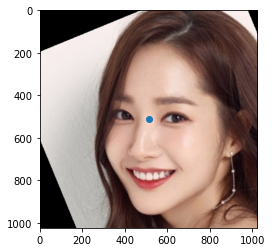

In [277]:
#실제사진
testimg = load_img(impath)
plt.imshow(((testimg+1)/2)[0].permute(1,2,0).detach().numpy())
plt.scatter(512,512) #original

## 인코딩 후 StyleGAN으로 Generate 된 사진들

In [302]:
testimg = load_img(impath)
l = train_latent(testimg)
print('latent training completed')

latent training completed


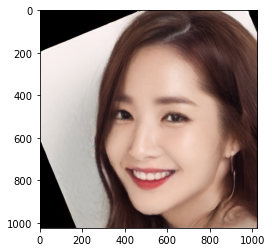

In [300]:
a = fatmaker(24,24,l,1024)
plt.imshow(np.array(a))

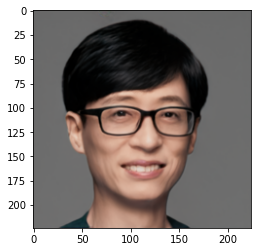

In [270]:
a = fatmaker(24,24,l,224)
plt.imshow(np.array(a))

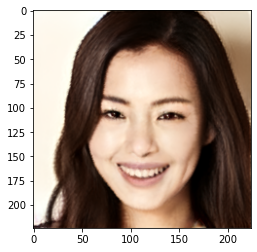

In [141]:
a = fatmaker(24,24,l,224)
plt.imshow(np.array(a))

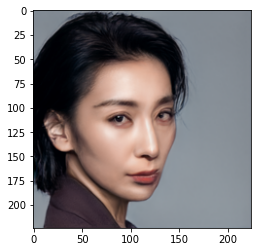

In [160]:
a = fatmaker(24,21,l,224)
plt.imshow(np.array(a))